Cargando: /root/Proyecto/EEG_Clasificador/data/brainbit/brainbit_MI_LR_preproc_final_for_model.npz
Recorte temporal aplicado: (40, 8, 1280) -> (40, 8, 960)
Aplicando Notch 60Hz...
Cargando pesos desde: /root/Proyecto/EEG_Clasificador/models/04_hybrid/winner_model/winner_nb2_h6_lr1e-03_do0.2_el1/final_model_winner.pt
Ejecutando TTA (promediando 7 variaciones por muestra)...


<ipython-input-12-b7ffaecdd923>:124: RuntimeWarning: filter_length (1057) is longer than the signal (960), distortion is likely. Reduce filter length or filter a longer signal.
  X_flat = mne.filter.notch_filter(X_flat, fs, [60.0], verbose=False)



RESULTADO FINAL (Mejorado): 0.5500 (55.00%)
              precision    recall  f1-score   support

        Left       0.56      0.45      0.50        20
       Right       0.54      0.65      0.59        20

    accuracy                           0.55        40
   macro avg       0.55      0.55      0.55        40
weighted avg       0.55      0.55      0.55        40



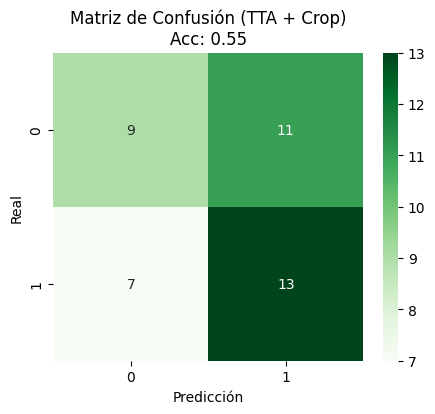

In [12]:
import os
import torch
import torch.nn as nn
import numpy as np
import copy
import mne
from scipy.signal import detrend
from pathlib import Path
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CONFIGURACIÓN
# ==========================================
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PROJ = Path("..").resolve().parent
# Ruta exacta de tu modelo ganador
MODEL_PATH = PROJ / "models" / "04_hybrid" / "winner_model" / "winner_nb2_h6_lr1e-03_do0.2_el1" / "final_model_winner.pt"
BRAINBIT_FILE = PROJ / "data" / "brainbit" / "brainbit_MI_LR_preproc_final_for_model.npz"

# ==========================================
# 2. DEFINICIÓN DE LA ARQUITECTURA
# ==========================================
def make_gn(num_channels, num_groups=8):
    g = min(num_groups, num_channels)
    while num_channels % g != 0 and g > 1: g -= 1
    return nn.GroupNorm(g, num_channels)

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, k, s=1, p=0, p_drop=0.2):
        super().__init__()
        self.dw = nn.Conv1d(in_ch, in_ch, k, s, p, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, 1, bias=False)
        self.norm = make_gn(out_ch)
        self.act = nn.ELU()
        self.dropout = nn.Dropout(p_drop)
    def forward(self, x): return self.dropout(self.act(self.norm(self.pw(self.dw(x)))))

class _CustomEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, batch_first, norm_first, return_attn=True):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout); self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()
    def forward(self, src):
        sa_out, _ = self.self_attn(src, src, src, need_weights=False)
        src = self.norm1(src + self.dropout1(sa_out))
        ff = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = self.norm2(src + self.dropout2(ff))
        return src, None

class _CustomEncoder(nn.Module):
    def __init__(self, layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(num_layers)])
    def forward(self, src):
        for lyr in self.layers: src, _ = lyr(src)
        return src, None

class EEGCNNTransformer(nn.Module):
    def __init__(self, n_ch=8, n_cls=2, d_model=144, n_heads=6, n_layers=1, n_dw_blocks=2, p_drop=0.2, **kwargs):
        super().__init__()
        stem = [nn.Conv1d(n_ch, 32, 129, 2, 64, bias=False), make_gn(32), nn.ELU(), nn.Dropout(p_drop)]
        blocks = []
        in_c, out_cs = 32, [64, 128, 256]
        for i in range(n_dw_blocks):
            blocks.append(DepthwiseSeparableConv(in_c, out_cs[i], k=(31 if i==0 else 15), s=2, p=(15 if i==0 else 7), p_drop=p_drop))
            in_c = out_cs[i]
        self.conv_t = nn.Sequential(*stem, *blocks)
        self.proj = nn.Conv1d(in_c, d_model, 1, bias=False)
        self.dropout = nn.Dropout(p_drop)
        enc = _CustomEncoderLayer(d_model, n_heads, 2*d_model, 0.1, True, False)
        self.encoder = _CustomEncoder(enc, n_layers)
        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, n_cls))
        self.pos_encoding = None

    def _positional_encoding(self, L, d):
        pos = torch.arange(0, L, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(0, d, dtype=torch.float32).unsqueeze(0)
        angle = pos / torch.pow(10000, (2 * (i//2)) / d)
        pe = torch.zeros(L, d); pe[:, 0::2] = torch.sin(angle[:, 0::2]); pe[:, 1::2] = torch.cos(angle[:, 1::2])
        return pe

    def forward(self, x):
        z = self.dropout(self.proj(self.conv_t(x))).transpose(1, 2)
        B, L, D = z.shape
        if self.pos_encoding is None or self.pos_encoding.shape[0] != L:
            self.pos_encoding = self._positional_encoding(L, D).to(z.device)
        z = z + self.pos_encoding[None, :L, :]
        z = torch.cat([self.cls.expand(B, -1, -1), z], dim=1)
        z, _ = self.encoder(z)
        return self.head(z[:, 0, :])

# ==========================================
# 3. PREPROCESAMIENTO
# ==========================================
def load_brainbit_processed(path_npz):
    print(f"Cargando: {path_npz}")
    d = np.load(path_npz)
    X, y, fs = d['X'], d['y'], int(d['fs']) # 160Hz
    
    # 1. Asegurar forma (N, 8, 1280)
    if X.ndim == 2: X = X[np.newaxis, ...]
    if X.shape[2] == 8: X = X.transpose(0, 2, 1) # Si viene como (N, T, C) -> (N, C, T)
    
    # 2. RECORTAR: Quedarse con los 6s centrales (muestras 160 a 1120)
    # Esto es vital si el modelo se entrenó con crops
    idx_start, idx_end = int(1.0 * fs), int(7.0 * fs)
    X6 = X[:, :, idx_start:idx_end] # (N, 8, 960)
    print(f"Recorte temporal aplicado: {X.shape} -> {X6.shape}")
    
    # 3. FILTRO NOTCH (60Hz) - Vital para BrainBit
    print("Aplicando Notch 60Hz...")
    X_flat = X6.reshape(X6.shape[0] * 8, -1).astype(np.float64)
    X_flat = mne.filter.notch_filter(X_flat, fs, [60.0], verbose=False)
    X6 = X_flat.astype(np.float32).reshape(X6.shape[0], 8, -1)
    
    # 4. Detrend (limpieza lineal)
    for i in range(len(X6)):
        X6[i] = detrend(X6[i], axis=1, type='linear')
        
    return X6, y, fs

# ==========================================
# 4. INFERENCIA CON TTA (Test Time Augmentation)
# ==========================================
def predict_with_tta(model, X, fs, device):
    model.eval()
    shifts_s = [-0.075, -0.05, -0.025, 0.0, 0.025, 0.05, 0.075] # Shifts en segundos
    all_probs = []
    
    print("Ejecutando TTA (promediando 7 variaciones por muestra)...")
    with torch.no_grad():
        for i in range(len(X)):
            x_base = X[i] # (8, 960)
            sample_probs = []
            
            for s_val in shifts_s:
                shift = int(round(s_val * fs))
                # Aplicar shift con padding 'edge' para no meter ceros
                if shift == 0: x = x_base
                elif shift > 0: x = np.pad(x_base[:, shift:], ((0,0),(0,shift)), mode='edge')[:, :960]
                else:          x = np.pad(x_base[:, :-abs(shift)], ((0,0),(abs(shift),0)), mode='edge')[:, :960]
                
                t_tens = torch.tensor(x[None, ...], dtype=torch.float32).to(device)
                logits = model(t_tens)
                probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
                sample_probs.append(probs)
            
            # Promediar las probabilidades de los shifts
            avg_prob = np.mean(sample_probs, axis=0)
            all_probs.append(avg_prob)
            
    return np.array(all_probs)

# ==========================================
# 5. EJECUCIÓN PRINCIPAL
# ==========================================
# Cargar datos con el preprocesamiento correcto
X, y, fs = load_brainbit_processed(BRAINBIT_FILE)

# Cargar Modelo
model = EEGCNNTransformer(
    n_ch=8, n_cls=2, d_model=144, n_heads=6, n_layers=1, n_dw_blocks=2, p_drop=0.0
).to(DEVICE)

print(f"Cargando pesos desde: {MODEL_PATH}")
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

# Predecir
probs = predict_with_tta(model, X, fs, DEVICE)
preds = np.argmax(probs, axis=1)

# Reporte
acc = accuracy_score(y, preds)
print("\n" + "="*40)
print(f"RESULTADO FINAL (Mejorado): {acc:.4f} ({acc*100:.2f}%)")
print("="*40)
print(classification_report(y, preds, target_names=['Left', 'Right']))

cm = confusion_matrix(y, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title(f'Matriz de Confusión (TTA + Crop)\nAcc: {acc:.2f}')
plt.xlabel('Predicción'); plt.ylabel('Real')
plt.show()

Con estandarizacion

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import copy
import mne
from scipy.signal import detrend
from pathlib import Path
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CONFIGURACIÓN
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PROJ = Path("..").resolve().parent
# Ruta exacta de tu modelo ganador
MODEL_PATH = PROJ / "models" / "04_hybrid" / "winner_model" / "winner_nb2_h6_lr1e-03_do0.2_el1" / "final_model_winner.pt"
BRAINBIT_FILE = PROJ / "data" / "brainbit" / "brainbit_MI_LR_preproc_final_for_model.npz"

# ==========================================
# 2. DEFINICIÓN DE LA ARQUITECTURA
# ==========================================
def make_gn(num_channels, num_groups=8):
    g = min(num_groups, num_channels)
    while num_channels % g != 0 and g > 1: g -= 1
    return nn.GroupNorm(g, num_channels)

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, k, s=1, p=0, p_drop=0.2):
        super().__init__()
        self.dw = nn.Conv1d(in_ch, in_ch, k, s, p, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, 1, bias=False)
        self.norm = make_gn(out_ch)
        self.act = nn.ELU()
        self.dropout = nn.Dropout(p_drop)
    def forward(self, x): return self.dropout(self.act(self.norm(self.pw(self.dw(x)))))

class _CustomEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, batch_first, norm_first, return_attn=True):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout); self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()
    def forward(self, src):
        sa_out, _ = self.self_attn(src, src, src, need_weights=False)
        src = self.norm1(src + self.dropout1(sa_out))
        ff = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = self.norm2(src + self.dropout2(ff))
        return src, None

class _CustomEncoder(nn.Module):
    def __init__(self, layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(num_layers)])
    def forward(self, src):
        for lyr in self.layers: src, _ = lyr(src)
        return src, None

class EEGCNNTransformer(nn.Module):
    def __init__(self, n_ch=8, n_cls=2, d_model=144, n_heads=6, n_layers=1, n_dw_blocks=2, p_drop=0.2, **kwargs):
        super().__init__()
        stem = [nn.Conv1d(n_ch, 32, 129, 2, 64, bias=False), make_gn(32), nn.ELU(), nn.Dropout(p_drop)]
        blocks = []
        in_c, out_cs = 32, [64, 128, 256]
        for i in range(n_dw_blocks):
            blocks.append(DepthwiseSeparableConv(in_c, out_cs[i], k=(31 if i==0 else 15), s=2, p=(15 if i==0 else 7), p_drop=p_drop))
            in_c = out_cs[i]
        self.conv_t = nn.Sequential(*stem, *blocks)
        self.proj = nn.Conv1d(in_c, d_model, 1, bias=False)
        self.dropout = nn.Dropout(p_drop)
        enc = _CustomEncoderLayer(d_model, n_heads, 2*d_model, 0.1, True, False)
        self.encoder = _CustomEncoder(enc, n_layers)
        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, n_cls))
        self.pos_encoding = None

    def _positional_encoding(self, L, d):
        pos = torch.arange(0, L, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(0, d, dtype=torch.float32).unsqueeze(0)
        angle = pos / torch.pow(10000, (2 * (i//2)) / d)
        pe = torch.zeros(L, d); pe[:, 0::2] = torch.sin(angle[:, 0::2]); pe[:, 1::2] = torch.cos(angle[:, 1::2])
        return pe

    def forward(self, x):
        z = self.dropout(self.proj(self.conv_t(x))).transpose(1, 2)
        B, L, D = z.shape
        if self.pos_encoding is None or self.pos_encoding.shape[0] != L:
            self.pos_encoding = self._positional_encoding(L, D).to(z.device)
        z = z + self.pos_encoding[None, :L, :]
        z = torch.cat([self.cls.expand(B, -1, -1), z], dim=1)
        z, _ = self.encoder(z)
        return self.head(z[:, 0, :])

# ==========================================
# 3. PREPROCESAMIENTO (CON ESTANDARIZACIÓN)
# ==========================================
def load_brainbit_processed(path_npz):
    print(f"Cargando: {path_npz}")
    d = np.load(path_npz)
    X, y, fs = d['X'], d['y'], int(d['fs']) # 160Hz
    
    # 1. Asegurar forma (N, 8, 1280)
    if X.ndim == 2: X = X[np.newaxis, ...]
    if X.shape[2] == 8: X = X.transpose(0, 2, 1) # Si viene como (N, T, C) -> (N, C, T)
    
    # 2. RECORTAR: Quedarse con los 6s centrales (muestras 160 a 1120)
    # Esto da (N, 8, 960)
    idx_start, idx_end = int(1.0 * fs), int(7.0 * fs)
    X6 = X[:, :, idx_start:idx_end] 
    print(f"Recorte temporal aplicado: {X.shape} -> {X6.shape}")
    
    # 3. FILTRO NOTCH (60Hz) - Vital para BrainBit
    print("Aplicando Notch 60Hz...")
    X_flat = X6.reshape(X6.shape[0] * 8, -1).astype(np.float64)
    X_flat = mne.filter.notch_filter(X_flat, fs, [60.0], verbose=False)
    X6 = X_flat.astype(np.float32).reshape(X6.shape[0], 8, -1)
    
    # 4. Detrend (limpieza lineal)
    for i in range(len(X6)):
        X6[i] = detrend(X6[i], axis=1, type='linear')

    # =======================================================
    # 5. ESTANDARIZACIÓN (AGREGADO PARA MATCH CON MODELO)
    # =======================================================
    print("Aplicando Estandarización (mu=0, std=1) por canal...")
    # Calculamos stats por canal sobre todo el batch actual
    for c in range(X6.shape[1]):
        mu = X6[:, c, :].mean()
        sd = X6[:, c, :].std()
        if sd < 1e-6: sd = 1.0 # Seguridad
        X6[:, c, :] = (X6[:, c, :] - mu) / sd
        
    return X6, y, fs

# ==========================================
# 4. INFERENCIA CON TTA (Test Time Augmentation)
# ==========================================
def predict_with_tta(model, X, fs, device):
    model.eval()
    shifts_s = [-0.075, -0.05, -0.025, 0.0, 0.025, 0.05, 0.075] # Shifts en segundos
    all_probs = []
    
    print("Ejecutando TTA (promediando 7 variaciones por muestra)...")
    with torch.no_grad():
        for i in range(len(X)):
            x_base = X[i] # (8, 960)
            sample_probs = []
            
            for s_val in shifts_s:
                shift = int(round(s_val * fs))
                # Aplicar shift con padding 'edge' para no meter ceros
                if shift == 0: x = x_base
                elif shift > 0: x = np.pad(x_base[:, shift:], ((0,0),(0,shift)), mode='edge')[:, :960]
                else:          x = np.pad(x_base[:, :-abs(shift)], ((0,0),(abs(shift),0)), mode='edge')[:, :960]
                
                t_tens = torch.tensor(x[None, ...], dtype=torch.float32).to(device)
                logits = model(t_tens)
                probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
                sample_probs.append(probs)
            
            # Promediar las probabilidades de los shifts
            avg_prob = np.mean(sample_probs, axis=0)
            all_probs.append(avg_prob)
            
    return np.array(all_probs)

# ==========================================
# 5. EJECUCIÓN PRINCIPAL
# ==========================================
# Cargar datos con el preprocesamiento correcto
X, y, fs = load_brainbit_processed(BRAINBIT_FILE)

# Cargar Modelo
model = EEGCNNTransformer(
    n_ch=8, n_cls=2, d_model=144, n_heads=6, n_layers=1, n_dw_blocks=2, p_drop=0.0
).to(DEVICE)

print(f"Cargando pesos desde: {MODEL_PATH}")
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

# Predecir
probs = predict_with_tta(model, X, fs, DEVICE)
preds = np.argmax(probs, axis=1)

# Reporte
acc = accuracy_score(y, preds)
print("\n" + "="*40)
print(f"RESULTADO FINAL: {acc:.4f} ({acc*100:.2f}%)")
print("="*40)
print(classification_report(y, preds, target_names=['Left', 'Right']))

cm = confusion_matrix(y, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title(f'Matriz de Confusión (TTA + Crop + Std)\nAcc: {acc:.2f}')
plt.xlabel('Predicción'); plt.ylabel('Real')
plt.show()

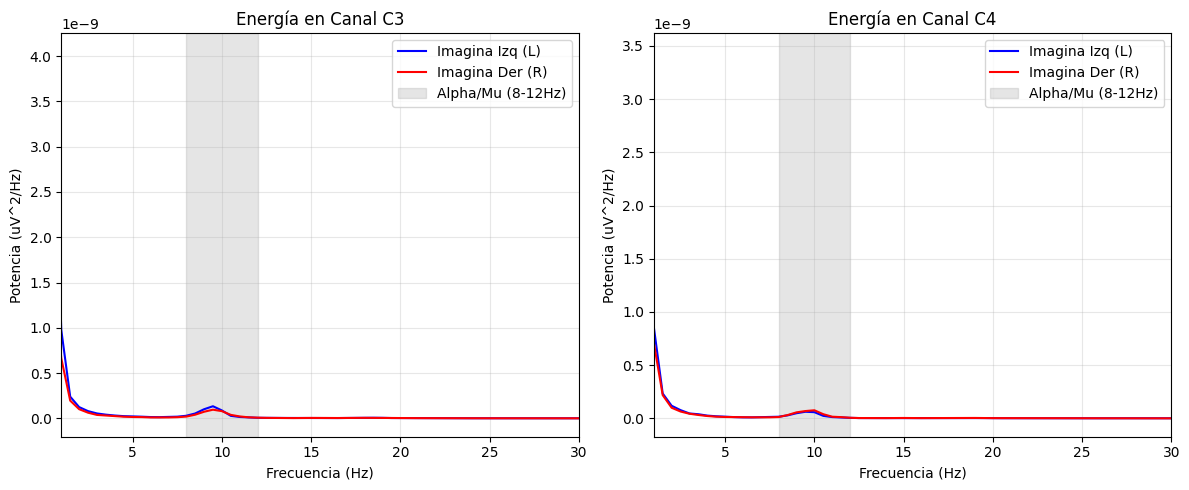

In [13]:
# ==========================================
# DIAGNÓSTICO VISUAL: PSD (Power Spectral Density)
# ==========================================
from scipy.signal import welch

def plot_psd_comparison(X, y, fs, ch_names=['C3', 'C4']):
    # X shape: (N_trials, N_channels, N_samples)
    # y shape: (N_trials,)
    
    # Índices de canales (ajusta según tu lista CHANNEL_ORDER)
    # Asumimos que en tu array de 8 canales: 
    # 0:C3, 1:C4, 2:Cz, 3:FC3, 4:FC4, 5:CP3, 6:CP4, 7:FCz (Ajustar si es diferente)
    ch_idx_map = {'C3': 0, 'C4': 1} 
    
    left_trials = X[y == 0] # Label 0 = Left
    right_trials = X[y == 1] # Label 1 = Right
    
    plt.figure(figsize=(12, 5))
    
    for i, ch_name in enumerate(ch_names):
        c_idx = ch_idx_map[ch_name]
        
        # Calcular PSD promedio para trials Left
        freqs, psd_left = welch(left_trials[:, c_idx, :], fs, nperseg=fs*2)
        mean_psd_left = np.mean(psd_left, axis=0)
        
        # Calcular PSD promedio para trials Right
        freqs, psd_right = welch(right_trials[:, c_idx, :], fs, nperseg=fs*2)
        mean_psd_right = np.mean(psd_right, axis=0)
        
        # Plot
        plt.subplot(1, 2, i+1)
        plt.plot(freqs, mean_psd_left, label='Imagina Izq (L)', color='blue')
        plt.plot(freqs, mean_psd_right, label='Imagina Der (R)', color='red')
        plt.axvspan(8, 12, color='gray', alpha=0.2, label='Alpha/Mu (8-12Hz)')
        plt.xlim(1, 30)
        plt.title(f'Energía en Canal {ch_name}')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Potencia (uV^2/Hz)')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Ejecutar diagnóstico
# Asegúrate de que X, y, fs vienen de tu carga anterior
plot_psd_comparison(X, y, fs)

Promediando 20 trials Izq y 20 trials Der...


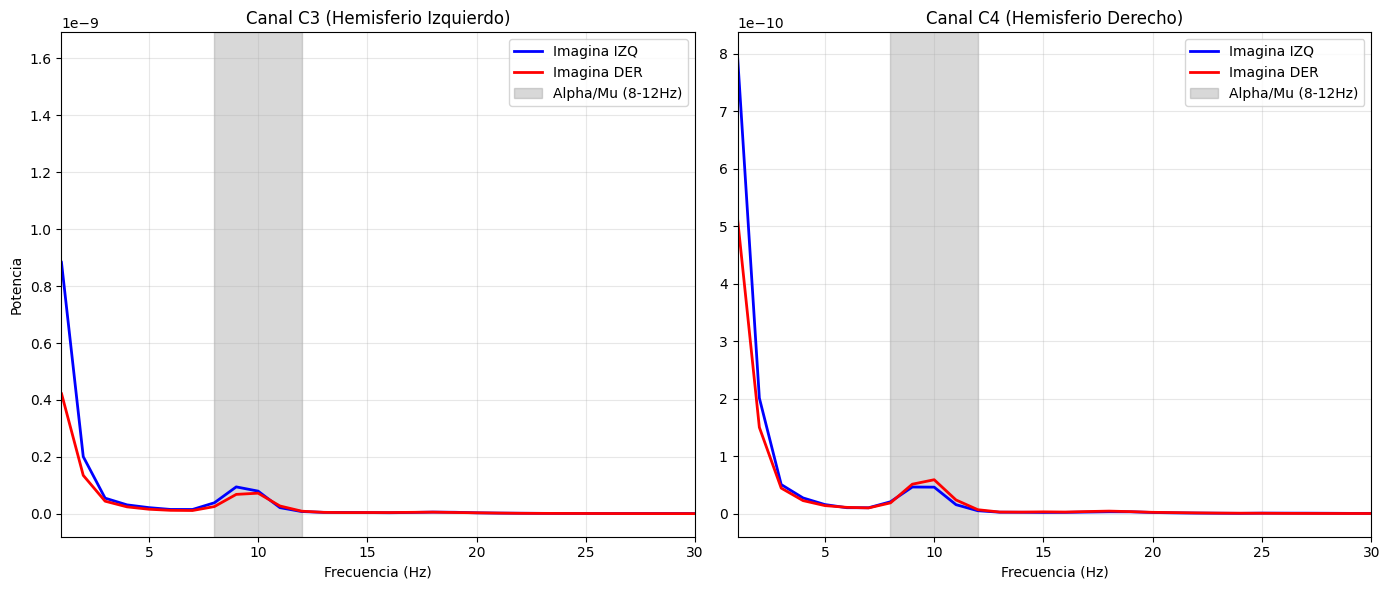

In [14]:
from scipy.signal import welch

def plot_psd_check(X, y, fs):
    # X shape: (N, 8, Time)
    # Asumimos canales: 0:C3 (Izquierdo), 1:C4 (Derecho) según tu lista CHANNEL_ORDER
    # Si tu orden es diferente, ajusta estos índices.
    
    c3_idx, c4_idx = 0, 1 
    
    # Separar trials
    trials_left = X[y == 0]  # Imaginaste Izquierda
    trials_right = X[y == 1] # Imaginaste Derecha
    
    print(f"Promediando {len(trials_left)} trials Izq y {len(trials_right)} trials Der...")

    plt.figure(figsize=(14, 6))
    
    # --- ANÁLISIS C3 (Hemisferio Izquierdo - Controla mano Derecha) ---
    plt.subplot(1, 2, 1)
    f_l, psd_l_c3 = welch(trials_left[:, c3_idx, :], fs, nperseg=fs)
    f_r, psd_r_c3 = welch(trials_right[:, c3_idx, :], fs, nperseg=fs)
    
    # Promedio a través de los trials
    plt.plot(f_l, np.mean(psd_l_c3, axis=0), label='Imagina IZQ', color='blue', linewidth=2)
    plt.plot(f_r, np.mean(psd_r_c3, axis=0), label='Imagina DER', color='red', linewidth=2)
    plt.title("Canal C3 (Hemisferio Izquierdo)")
    plt.axvspan(8, 12, color='gray', alpha=0.3, label='Alpha/Mu (8-12Hz)')
    plt.xlim(1, 30)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Potencia")

    # --- ANÁLISIS C4 (Hemisferio Derecho - Controla mano Izquierda) ---
    plt.subplot(1, 2, 2)
    f_l, psd_l_c4 = welch(trials_left[:, c4_idx, :], fs, nperseg=fs)
    f_r, psd_r_c4 = welch(trials_right[:, c4_idx, :], fs, nperseg=fs)
    
    plt.plot(f_l, np.mean(psd_l_c4, axis=0), label='Imagina IZQ', color='blue', linewidth=2)
    plt.plot(f_r, np.mean(psd_r_c4, axis=0), label='Imagina DER', color='red', linewidth=2)
    plt.title("Canal C4 (Hemisferio Derecho)")
    plt.axvspan(8, 12, color='gray', alpha=0.3, label='Alpha/Mu (8-12Hz)')
    plt.xlim(1, 30)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlabel("Frecuencia (Hz)")

    plt.tight_layout()
    plt.show()

# Ejecutar con tus datos cargados
plot_psd_check(X, y, fs)